### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from src import code_simulator, code, noise, recovery

### Parameters

In [2]:
rotation_symmetries = [2, 3, 4]
loss_noise_values = [0.5, 0.3, 0.1, 0.01]
number_of_filled_levels_values = range(1, 20)

### Fidelities of Trivial Code

In [3]:
trivial_fidelities = [code_simulator.get_fidelity_of_code_under_loss_noise(code.trivial_code, loss_noise_amount, False) for loss_noise_amount in loss_noise_values]

### Fidelities of Binomial Code

This will take forever to run on the first time because it needs to calculate a lot of stuff, but subsequent runs should be near instantaneous because all the calculation values are saved to files.

In [4]:
%%time

binomial_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(number_of_filled_levels_values), 2))
binomial_photon_numbers = np.zeros((len(rotation_symmetries), len(number_of_filled_levels_values)))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, number_of_filled_levels in enumerate(number_of_filled_levels_values):
			binomial_code = code.get_binomial_code(rotation_symmetry, number_of_filled_levels, (number_of_filled_levels + 2) * rotation_symmetry)
			binomial_fidelities[i,j,k,0] = code_simulator.get_fidelity_of_code_under_loss_noise(binomial_code, loss_noise_amount, False)
			binomial_fidelities[i,j,k,1] = code_simulator.get_fidelity_of_code_under_loss_noise(binomial_code, loss_noise_amount, True)
			binomial_photon_numbers[i,k] = qt.expect(qt.num(binomial_code.physical_dimension), 1 / 2 * (binomial_code.zero_encoding * binomial_code.zero_encoding.dag() + binomial_code.one_encoding * binomial_code.one_encoding.dag()))

CPU times: user 183 ms, sys: 19.3 ms, total: 203 ms
Wall time: 202 ms


### Fidelities of Random Codes

This will probably always take a bit.

In [5]:
%%time

random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(number_of_filled_levels_values), 2))
random_photon_numbers = np.zeros((len(rotation_symmetries), len(number_of_filled_levels_values)))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, number_of_filled_levels in enumerate(number_of_filled_levels_values):
			random_code = code.make_random_code(rotation_symmetry, number_of_filled_levels, (number_of_filled_levels + 2) * rotation_symmetry)
			random_fidelities[i,j,k,0] = code_simulator.get_fidelity_of_code_under_loss_noise(random_code, loss_noise_amount, False)
			random_fidelities[i,j,k,1] = code_simulator.get_fidelity_of_code_under_loss_noise(random_code, loss_noise_amount, True)
			random_photon_numbers[i,k] = qt.expect(qt.num(random_code.physical_dimension), 1 / 2 * (random_code.zero_encoding * random_code.zero_encoding.dag() + random_code.one_encoding * random_code.one_encoding.dag()))

CPU times: user 8min 15s, sys: 4min 45s, total: 13min 1s
Wall time: 6min 12s


### Plots of Error Rates vs. Average Number

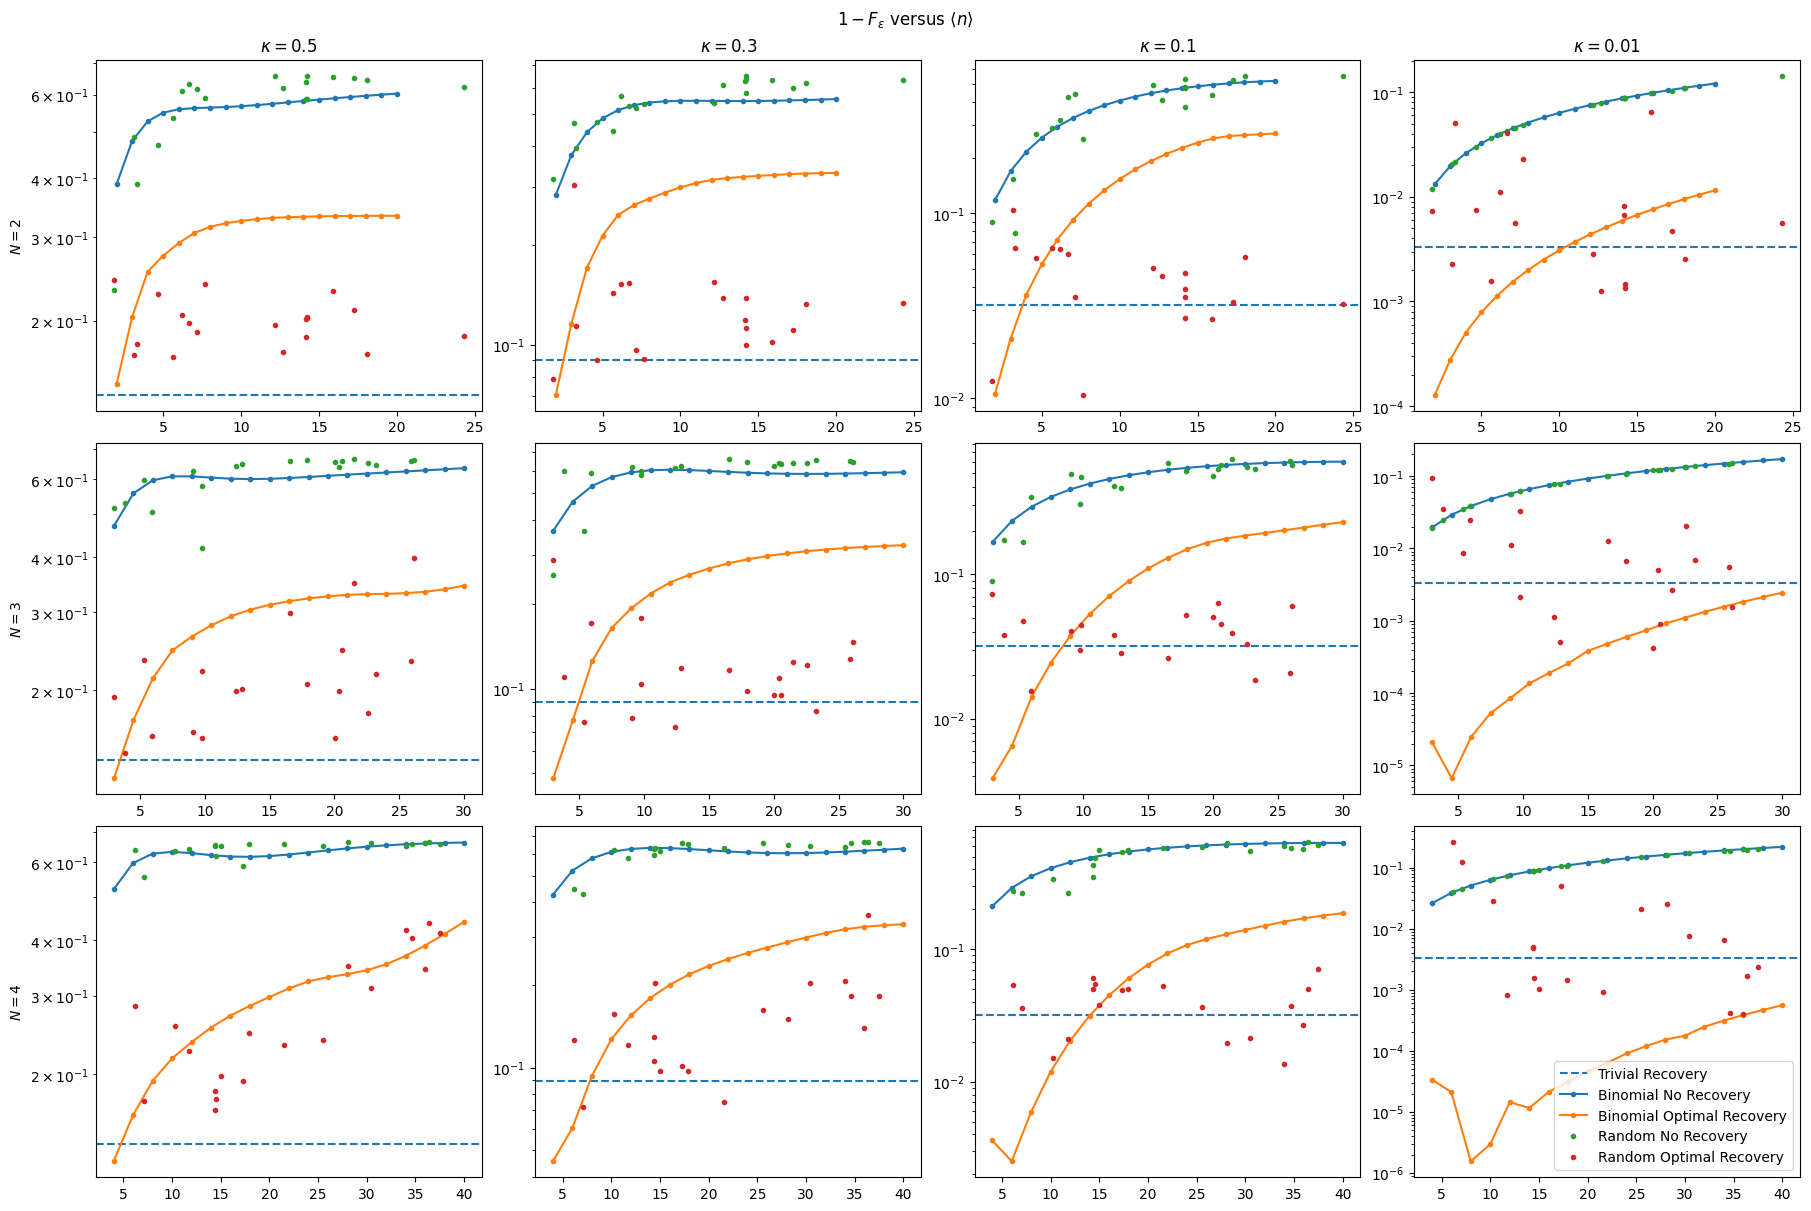

In [6]:
fig, axs = plt.subplots(len(rotation_symmetries), len(loss_noise_values), figsize=(18, 12), constrained_layout=True)
fig.suptitle(r"$1 - F_\epsilon$ versus $\langle n\rangle$")
for i, rotation_symmetry in enumerate(rotation_symmetries):
	axs[i,0].set_ylabel(f"$N={rotation_symmetry}$")
for i, loss_noise_amount in enumerate(loss_noise_values):
	axs[0,i].set_title(f"$\\kappa={loss_noise_amount}$")

for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		axs[i,j].axhline(1 - trivial_fidelities[j], linestyle="--", label="Trivial Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,0], ".-", label="Binomial No Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,1], ".-", label="Binomial Optimal Recovery")
		axs[i,j].semilogy(random_photon_numbers[i], 1 - random_fidelities[i,j,:,0], ".", label="Random No Recovery")
		axs[i,j].semilogy(random_photon_numbers[i], 1 - random_fidelities[i,j,:,1], ".", label="Random Optimal Recovery")

axs[-1,-1].legend()
plt.show()